In [17]:
import torch
from torchvision import datasets, transforms, models
import torch.nn.functional as F
from torch import nn
from torch import optim
from collections import OrderedDict
from torch.utils.data import DataLoader

from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt

import random
from random import shuffle
from util import show_clean_dirty_images
from model import Denoiser

# Loading the data

In [19]:
random.seed(2)
np.random.seed = 2

# Set Variables
path_train_images_clean = "E:/sheets/dl/train/clean/"
path_train_images_dirty = "E:/sheets/dl/train/dirty/"
path_test_images_clean = "E:/sheets/dl/test/clean/"
path_test_images_dirty = "E:/sheets/dl/test/dirty/"

doc_creator_degenerations = {
    'Bleed_0', 
    'Blur_Complete_0', 
    'CharDeg_0', 
    'Hole_0', 
    'Phantom_FREQUENT_0', 
    'Phantom_RARE_0',
    'Shadow_Bottom',
    'Shadow_Left',
    'Shadow_Right',
    'Shadow_Top'}

a4_size = (2480, 3508)
split_size = 0.85
batch_size = 2

In [3]:
train_images_clean = sorted(os.listdir(path_train_images_clean))
train_images_dirty = sorted(os.listdir(path_train_images_dirty))

test_images_clean = sorted(os.listdir(path_test_images_clean))
test_images_dirty = sorted(os.listdir(path_test_images_dirty))

print(f'Number of Images in train:\n\tclean: {len(train_images_clean)}\n\tdirty: {len(train_images_dirty)}')
print(f'Number of Images in test:\n\tclean: {len(test_images_clean)}\n\tdirty: {len(test_images_dirty)}')

Number of Images in train:
	clean: 4
	dirty: 40
Number of Images in test:
	clean: 1
	dirty: 10


In [4]:
def remove_degeneration_name(file):
    for degeneration in doc_creator_degenerations:
        if degeneration in file:
            return file.replace(degeneration, "")
        
    raise Exception(f'No degeneration encoding found in {file}')

In [5]:
# Create a map of the clean image to the dirty images
train_images = {}

for image_dirty in train_images_dirty:
    image_clean = remove_degeneration_name(image_dirty)
    if image_clean not in train_images: 
        train_images[image_clean] = [image_dirty]
    else:
        train_images[image_clean].append(image_dirty)

In [6]:
# Defining the Transformations for testing images
transform = transforms.Compose([
	transforms.Resize(a4_size), 
	transforms.ToTensor(), 
	transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

def convert_to_tensor(image):
    return transform(Image.open(image).convert('RGB')) # TODO: Optimize -> convert to black and white

In [7]:
train_images_transform = []

for image_clean in train_images:
    file_image_clean = os.path.join(path_train_images_clean, image_clean)
    image_clean_transform = convert_to_tensor(file_image_clean)
    for image_dirty in train_images[image_clean]:
         file_image_dirty = os.path.join(path_train_images_dirty, image_dirty)
         image_dirty_transform = convert_to_tensor(file_image_dirty)
         train_images_transform.append((image_clean_transform, image_dirty_transform))

In [8]:
shuffle(train_images_transform)

## Show some images

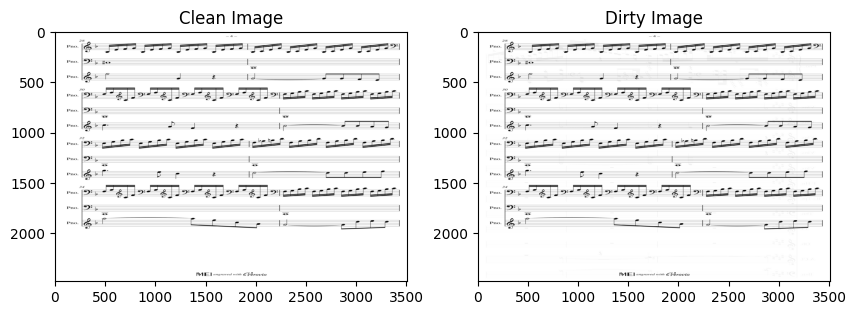

In [9]:
show_clean_dirty_images(train_images_transform[10][0], train_images_transform[10][1])

In [20]:
index = int(len(train_images_transform)*split_size)

train_dataset = train_images_transform[:index]
valid_dataset = train_images_transform[index:]

train_loader = DataLoader(train_dataset, batch_size=batch_size)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size)

# Defining the Model and Hyperparameters

In [31]:
# Import the model
class Denoiser(nn.Module):
	def __init__(self):
		super().__init__()
		# defining the encoder
		self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
		self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
		
		# defining the pooling layer
		self.pool = nn.MaxPool2d(2, 2)

		# defining the decoder
		self.conv2d_1 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
		self.conv2d_2 = nn.Conv2d(64, 32, kernel_size=3, padding=1)
		self.conv2d_3 = nn.Conv2d(32, 1, kernel_size=3, padding=1)

	def forward(self, x):
		# passing the image through encoder
		x = self.pool(F.relu(self.conv1(x)))
		x = self.pool(F.relu(self.conv2(x)))

		# passing the encoded part through decoder
		x = F.relu(self.conv2d_1(x))
		x = F.upsample(x, scale_factor=2, mode='nearest')
		x = F.relu(self.conv2d_2(x))
		x = F.upsample(x, scale_factor=2, mode='nearest')
		x = F.sigmoid(self.conv2d_3(x))

		return x
model = Denoiser()
print(model)

Denoiser(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2d_1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2d_2): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2d_3): Conv2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


In [22]:
# defining the loss function
criterion = nn.MSELoss()

# defining the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [23]:
cuda_available = torch.cuda.is_available()

if cuda_available:
	print('Cuda available...\tTraining on GPU')
	model = model.cuda()
else:
	print('CUDA not available...\tTraining on CPU')

CUDA not available...	Training on CPU


# Training

In [30]:
epochs = 1
training_loss = 0
min_valid_loss = np.Inf
save_path = "../save/"

for e in range(epochs):
    
    for images, targets in train_loader:
        
        if cuda_available:
            images, targets = images.cuda(), targets.cuda()
        
        outputs = model(images)
        loss = criterion(outputs, targets)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        training_loss += loss.item()
    
    with torch.no_grad():
        
        valid_loss = 0
        
        for images, targets in valid_loader:
            if cuda_available:
                images, targets = images.cuda(), targets.cuda()
        
            outputs = model(images)
            loss = criterion(outputs, targets)
            
            valid_loss += loss.item()
    
        if valid_loss < min_valid_loss:
            print('Loss Decreased..({:.3f} -> {:.3f})  Saving Model..'.format(valid_loss, min_valid_loss))
            torch.save(model.state_dict(), save_path)
            min_valid_loss = valid_loss/len(valid_loader)
            
    print('Epoch: {}/{} -- Training Loss: {:.3f} -- Testing Loss: {:.3f}'.format(e+1, epochs, training_loss/len(train_loader), \
                                                                                 valid_loss/len(valid_loader)))
    training_loss = 0

RuntimeError: Given groups=1, weight of size [32, 1, 3, 3], expected input[2, 3, 2480, 3508] to have 1 channels, but got 3 channels instead